# import

In [33]:
import pandas as pd
import datetime as dt
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1200)

In [35]:
customers_db = pd.read_csv('archive/olist_customers_dataset.csv')
order_items_db = pd.read_csv("archive/olist_order_items_dataset.csv")
order_payments_db = pd.read_csv("archive/olist_order_payments_dataset.csv")
orders_db = pd.read_csv("archive/olist_orders_dataset.csv")
products_db = pd.read_csv("archive/olist_products_dataset.csv")
sellers_db = pd.read_csv("archive/olist_sellers_dataset.csv")
category_db = pd.read_csv("archive/product_category_name_translation.csv")
geolocation_db = pd.read_csv("archive/olist_geolocation_dataset.csv")
product_reviews_db = pd.read_csv("archive/olist_order_reviews_dataset.csv")

# merge

In [36]:
result = pd.merge(customers_db, orders_db, on='customer_id', how='outer')
result = pd.merge(result, order_payments_db, on='order_id', how='outer')
result = pd.merge(result, orders_db, on='order_id', how='outer')
result = pd.merge(result, product_reviews_db, on='order_id', how='outer')
result = pd.merge(result, order_items_db, on='order_id', how='outer')
result = pd.merge(result, sellers_db, on='seller_id', how='outer')
result = pd.merge(result, products_db, on='product_id', how='outer')
result = pd.merge(result, category_db, on='product_category_name', how='outer')

In [37]:
df = result.drop(columns=['review_id', 'product_width_cm', 'product_height_cm', 'product_length_cm', 'product_weight_g',
                 'product_category_name', 'customer_id_y', 'order_purchase_timestamp_y', 'order_status_y', 'order_estimated_delivery_date_x', 'order_delivered_customer_date_x', 'order_delivered_carrier_date_x', 'order_approved_at_x'])

In [38]:
df.rename(columns={'customer_id_x': 'customer_id', 'order_status_x': 'order_status', 'order_delivered_customer_date_y': 'order_delivered_customer_date', 'order_estimated_delivery_date_y': 'order_estimated_delivery_date',
          'order_purchase_timestamp_x': 'order_purchase_timestamp', 'order_approved_at_y': 'order_approved_at', 'order_delivered_carrier_date_y': 'order_delivered_carrier_date'}, inplace=True)

In [39]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(
    df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(
    df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(
    df['order_estimated_delivery_date'])
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])

# Recence

In [40]:
last_order = pd.DataFrame(df.groupby(["customer_unique_id"])[
                          'order_purchase_timestamp'].max()).reset_index()
last_order.rename({'order_purchase_timestamp': 'last_order'},
                  axis=1, inplace=True)

In [41]:
df = df.merge(last_order, how='inner', on=["customer_unique_id"])

In [42]:
date_max = df['order_purchase_timestamp'].max() + dt.timedelta(days=1)


def recence(date):
    if date_max - date < dt.timedelta(days=91):
        return 15
    elif date_max - date < dt.timedelta(days=182):
        return 10
    elif date_max - date < dt.timedelta(days=273):
        return 6
    elif date_max - date < dt.timedelta(days=365):
        return 3
    else:
        return 0


df['recence'] = df['last_order'].apply(lambda x: recence(x))


# Frequence

In [43]:
def frequence(date):
    if date_max - date < dt.timedelta(days=365):
        return 3
    else:
        return 0


df['frequence'] = df['last_order'].apply(lambda x: frequence(x))

# Montant

In [44]:
df.groupby(["customer_unique_id"])['price'].max().reset_index()

,customer_unique_id,price
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00
...,...,...
96091,fffcf5a5ff07b0908bd4e2dbc735a684,890.00
96092,fffea47cd6d3cc0a88bd621562a9d061,64.89
96093,ffff371b4d645b6ecea244b27531430a,89.90
96094,ffff5962728ec6157033ef9805bacc48,115.00


In [45]:
prix_total = pd.DataFrame(df.groupby(["customer_unique_id"])[
                          'price'].sum()).reset_index()
prix_total.rename({'price': 'prix_total'}, axis=1, inplace=True)

In [46]:
df = pd.merge(df, prix_total, on='customer_unique_id', how='inner')

In [47]:
df['montant'] = (df['prix_total']/50)

In [48]:
df['montant'] = df['montant'].round()

In [ ]:
df

# total 

In [49]:
df["total_rfm"] = df["recence"] + df["frequence"] + df["montant"]

# groupby

In [50]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,seller_zip_code_prefix,seller_city,seller_state,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name_english,last_order,recence,frequence,prix_total,montant,total_rfm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,1.0,credit_card,2.0,146.87,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.0,NaN,NaN,2017-05-26 00:00:00,2017-05-30 22:34:40,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,8577.0,itaquaquecetuba,SP,41.0,1141.0,1.0,office_furniture,2017-05-16 15:05:35,0,0,124.99,2.0,2.0
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,1.0,credit_card,1.0,275.79,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19,1.0,NaN,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",2017-11-29 00:00:00,2017-12-01 19:41:59,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,8577.0,itaquaquecetuba,SP,41.0,1141.0,1.0,office_furniture,2017-11-09 00:50:13,3,3,225.98,5.0,11.0
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,1.0,credit_card,1.0,275.79,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19,1.0,NaN,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",2017-11-29 00:00:00,2017-12-01 19:41:59,2.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-11-23 00:47:18,112.99,24.90,8577.0,itaquaquecetuba,SP,41.0,1141.0,1.0,office_furniture,2017-11-09 00:50:13,3,3,225.98,5.0,11.0
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,1.0,credit_card,7.0,140.61,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12,3.0,NaN,"Produto compatível com seu valor, muito bonito...",2017-05-27 00:00:00,2017-05-28 02:43:16,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 22:22:56,124.99,15.62,8577.0,itaquaquecetuba,SP,41.0,1141.0,1.0,office_furniture,2017-05-07 20:11:26,0,0,124.99,2.0,2.0
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,1.0,credit_card,10.0,137.58,2018-02-04 22:29:19,2018-02-19 18:21:47,2018-02-28 21:09:00,2018-03-22,4.0,NaN,Entregou antes do prazo,2018-03-01 00:00:00,2018-03-02 11:11:24,1.0,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-02-18 21:29:19,106.99,30.59,8577.0,itaquaquecetuba,SP,41.0,1141.0,1.0,office_furniture,2018-02-03 19:45:40,6,3,106.99,2.0,11.0


<AxesSubplot: >

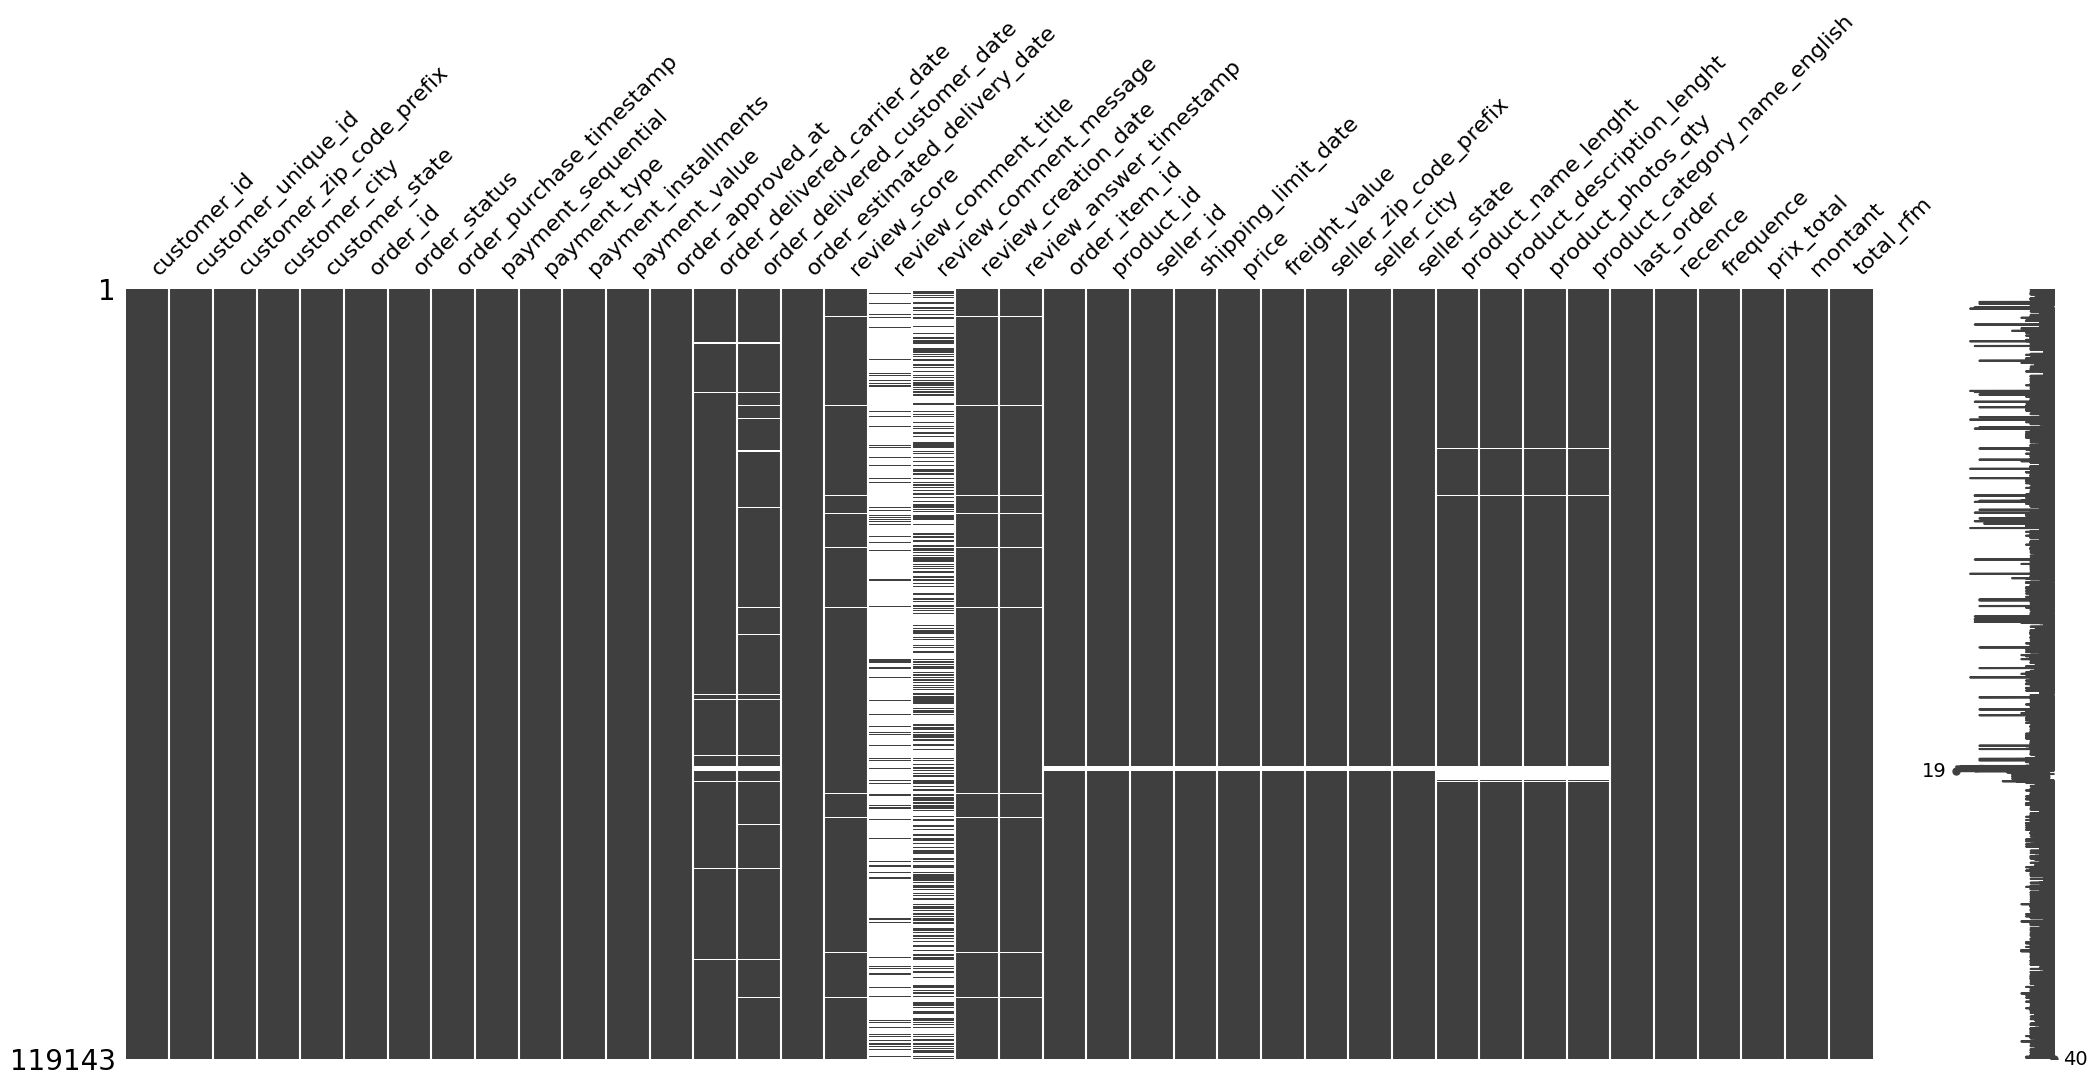

In [51]:
msno.matrix(df)

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 119142
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    119143 non-null  object        
 1   customer_unique_id             119143 non-null  object        
 2   customer_zip_code_prefix       119143 non-null  int64         
 3   customer_city                  119143 non-null  object        
 4   customer_state                 119143 non-null  object        
 5   order_id                       119143 non-null  object        
 6   order_status                   119143 non-null  object        
 7   order_purchase_timestamp       119143 non-null  datetime64[ns]
 8   payment_sequential             119140 non-null  float64       
 9   payment_type                   119140 non-null  object        
 10  payment_installments           119140 non-null  float64       
 11  

In [120]:
df['payment_installments'].value_counts()

1.0     59446
2.0     13838
3.0     11889
4.0      8072
10.0     6976
5.0      6097
8.0      5120
6.0      4674
7.0      1848
9.0       739
12.0      168
15.0       93
18.0       38
24.0       34
11.0       26
20.0       21
13.0       19
14.0       16
17.0        8
16.0        7
21.0        6
0.0         3
23.0        1
22.0        1
Name: payment_installments, dtype: int64

In [122]:
df = df[df['payment_installments'] <= 4]

In [126]:
df = df[df['payment_installments'] != 0]

In [127]:
df['payment_installments'].value_counts()

1.0    59446
2.0    13838
3.0    11889
4.0     8072
Name: payment_installments, dtype: int64

In [143]:
df = df.dropna()

In [169]:
sum_col = ['payment_value','total_rfm']
mode_col = ['last_order','order_status','customer_zip_code_prefix','customer_state','payment_type','product_category_name_english','customer_zip_code_prefix','customer_city']
mean_col = ['prix_total','montant','frequence', 'payment_value','review_score','freight_value','product_name_lenght','product_description_lenght','product_photos_qty','price']
last_col = ['payment_installments','order_purchase_timestamp']

dict_agg = {}

for col in mode_col:
    dict_agg[f'{col}'] = pd.Series.mode

for col in last_col:
    dict_agg[f'{col}'] = 'last'

for col in mean_col:
    dict_agg[f'{col}'] = 'mean'

for col in sum_col:
    dict_agg[f'{col}'] = 'sum'

In [170]:
df2 = df.groupby(df['customer_unique_id']).agg(dict_agg)

In [171]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7251 entries, 000ec5bff359e1c0ad76a81a45cb598f to fff3e1d7bc75f11dc7670619b2e61840
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   last_order                     7251 non-null   datetime64[ns]
 1   order_status                   7251 non-null   object        
 2   customer_zip_code_prefix       7251 non-null   object        
 3   customer_state                 7251 non-null   object        
 4   payment_type                   7251 non-null   object        
 5   product_category_name_english  7251 non-null   object        
 6   customer_city                  7251 non-null   object        
 7   payment_installments           7251 non-null   float64       
 8   order_purchase_timestamp       7251 non-null   datetime64[ns]
 9   prix_total                     7251 non-null   float64       
 10  montant                       

In [172]:
exemple = type(df2['payment_type'][df2.index == '000e309254ab1fc5ba99dd469d36bdb4'].values) # mask 
exemple

numpy.ndarray

In [173]:
(df2['payment_type'][df2.index == '000e309254ab1fc5ba99dd469d36bdb4'].values)

array([], dtype=object)

In [175]:
for col in mode_col:
    df2[col]= df2[col].apply(lambda x: x[0] if type(x) == exemple else x)

In [176]:
# création d'un dictionnaire pour une réduction des catégories

categories = {

 'health_beauty': 'Health_Beauty',
 'perfumery': 'Health_Beauty',
 'computers': 'Technology',
 'pc_gamer' : 'Technology',
 'computers_accessories': 'Technology',
 'electronics': 'Technology',
 'tablets_printing_image': 'Technology',
 'telephony': 'Technology',
 'fixed_telephony': 'Technology',
 'auto': 'Automotive',
 'small_appliances_home_oven_and_coffee': 'Home',
 'home_comfort_2': 'Home',
 'home_appliances_2': 'Home',
 'home_confort': 'Home',
 'air_conditioning': 'Home',
 'small_appliances': 'Home',
 'bed_bath_table': 'Home',
 'furniture_decor': 'Home',
 'housewares': 'Home',
 'home_appliances': 'Home',
 'home_comfort': 'Home',
 'kitchen_dining_laundry_garden_furniture': 'Home',
 'portable_kitchen_food_preparers' : 'Home',
 'fashio_female_clothing': 'Fashion_Accessories',
 'luggage_accessories': 'Fashion_Accessories',
 'fashion_bags_accessories': 'Fashion_Accessories',
 'fashion_shoes': 'Fashion_Accessories',
 'watches_gifts': 'Fashion_Accessories',
 'fashion_male_clothing': 'Fashion_Accessories',
 'fashion_female_clothing': 'Fashion_Accessories',
 'fashion_childrens_clothes': 'Fashion_Accessories',
 'fashion_underwear_beach': 'Fashion_Accessories',
 'fashion_sport': 'Fashion_Accessories',
 'sports_leisure': 'Sports_Leisure',
 'food_drink': 'Food_Beverage',
 'la_cuisine': 'Food_Beverage',
 'food': 'Food_Beverage',
 'drinks': 'Food_Beverage',
 'baby': 'Baby',
 'diapers_and_hygiene': 'Baby',
 'stationery': 'Office_Supplies',
 'office_furniture': 'Office_Supplies',
 'flowers': 'Gardening',
 'costruction_tools_garden': 'Gardening',
 'books_general_interest': 'Books',
 'books_technical': 'Books',
 'books_imported': 'Books',
'cds_dvds_musicals': 'Books',
 'dvds_blu_ray': 'Books',
 'art': 'Arts_Music',
 'audio': 'Arts_Music',
 'music': 'Arts_Music',
 'arts_and_craftmanship': 'Arts_Music',
 'cine_photo': 'Arts_Music',
 'musical_instruments': 'Arts_Music',
 'toys': 'Toys_Games',
 'consoles_games': 'Toys_Games',
 'cool_stuff': 'Toys_Games',
 'party_supplies': 'Party_Supplies',
 'christmas_supplies': 'Party_Supplies',
 'home_construction': 'Construction_Tools',
 'costruction_tools_tools': 'Construction_Tools',
 'construction_tools_construction': 'Construction_Tools',
 'garden_tools': 'Construction_Tools',
 'construction_tools_lights': 'Construction_Tools',
 'construction_tools_safety': 'Construction_Tools',
 'pet_shop': 'Pet_Supplies',
 'industry_commerce_and_business': 'Agro_Industry_Commerce',
 'agro_industry_and_commerce': 'Agro_Industry_Commerce',
 'furniture_mattress_and_upholstery': 'Furniture',
 'furniture_living_room': 'Furniture',
 'furniture_bedroom': 'Furniture',
 'market_place': 'Market_place',
 'signaling_and_security': 'Signaling_Security',
 'security_and_services': 'Signaling_Security'
 
 }
# réduire le nombre des catégories

df2["product_category_name_english"] = df2["product_category_name_english"].map(categories)

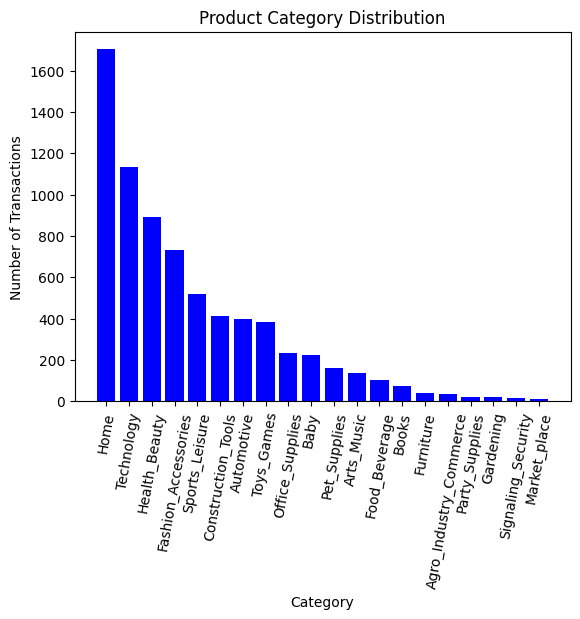

In [177]:
category_counts = df2['product_category_name_english'].value_counts()
category_names = category_counts.index

plt.bar(category_names, category_counts, color='blue')
plt.title('Product Category Distribution')
plt.xlabel('Category')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=80)

plt.show()

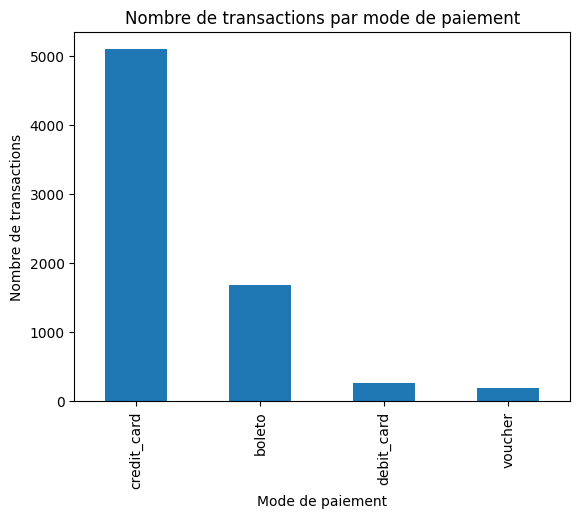

In [178]:
# Création du graphique
payment_type_counts = df2['payment_type'].value_counts()
payment_type_counts.plot.bar()
plt.xlabel('Mode de paiement')
plt.ylabel('Nombre de transactions')
plt.title('Nombre de transactions par mode de paiement')
plt.show()

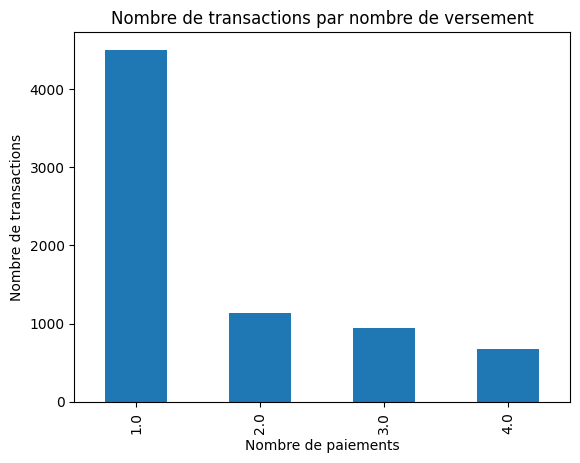

In [186]:
# Création du graphique
payment_installments_count = df2['payment_installments'].value_counts()
payment_installments_count.plot.bar()
plt.xlabel('Nombre de paiements')
plt.ylabel('Nombre de transactions')
plt.title('Nombre de transactions par nombre de versement')
plt.show()

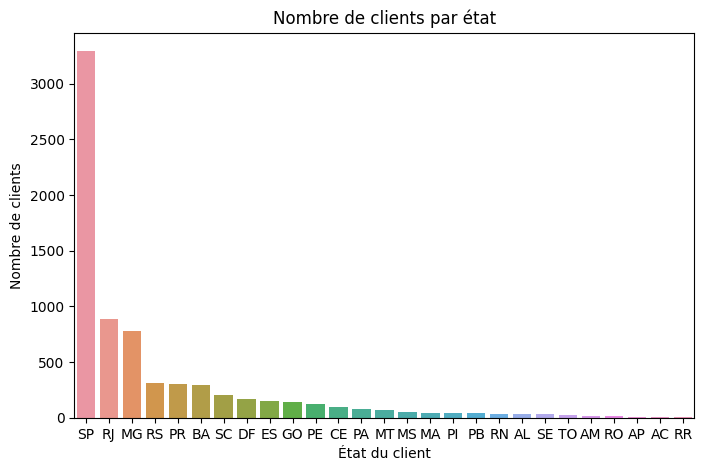

In [189]:
#Création du graphique
plt.figure(figsize=(8,5))
sns.countplot(x='customer_state',data=df2, order = df2['customer_state'].value_counts().index)
plt.xlabel('État du client')
plt.ylabel('Nombre de clients')
plt.title('Nombre de clients par état')
plt.show()

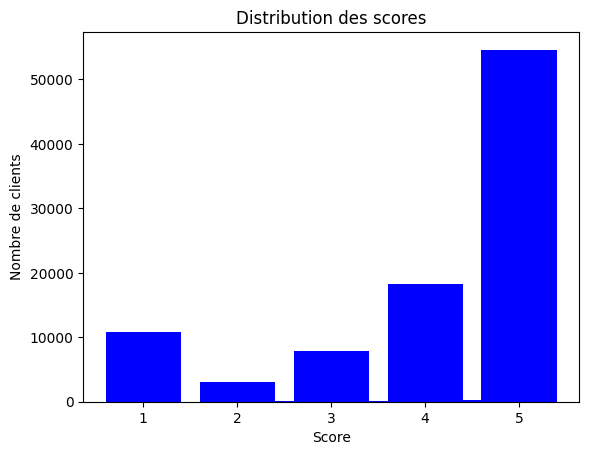

In [ ]:
df_review = df2[['review_score', 'prix_total']].groupby('review_score').count().reset_index()

# tracer un diagramme à barres
plt.bar(df_review['review_score'], df_review['prix_total'], color='b')
plt.title('Distribution des scores')
plt.xlabel('Score')
plt.ylabel('Nombre de clients')
plt.show()

In [191]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7251 entries, 000ec5bff359e1c0ad76a81a45cb598f to fff3e1d7bc75f11dc7670619b2e61840
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   last_order                     7251 non-null   datetime64[ns]
 1   order_status                   7251 non-null   object        
 2   customer_zip_code_prefix       7251 non-null   int64         
 3   customer_state                 7251 non-null   object        
 4   payment_type                   7251 non-null   object        
 5   product_category_name_english  7251 non-null   object        
 6   customer_city                  7251 non-null   object        
 7   payment_installments           7251 non-null   float64       
 8   order_purchase_timestamp       7251 non-null   datetime64[ns]
 9   prix_total                     7251 non-null   float64       
 10  montant                       

In [195]:
df2['prix_total'].describe()

count    7251.000000
mean      129.975730
std       245.048375
min         4.900000
25%        44.055000
50%        80.000000
75%       144.900000
max      9520.140000
Name: prix_total, dtype: float64

In [2]:
import pandas as pd

In [4]:
df_cluster = pd.read_csv('df_cluster.csv')

In [12]:
df_cluster.head()

,customer_state,payment_type,product_category_name_english,prix_total,montant,frequence,payment_installments,payment_value,review_score,freight_value,product_description_lenght,product_photos_qty,price
0,SP,credit_card,Home,1957.72,39.0,3,5.866586,2376.514496,3.736287,49.007927,1053.819932,2.249287,951.699434
1,SP,credit_card,Technology,2919.40,58.0,3,5.800000,19380.811000,2.300000,30.883583,1150.800000,2.033333,584.090833
2,SP,credit_card,Home,99.00,2.0,3,2.888591,188.530450,4.122051,20.903707,1100.523222,2.483189,128.196077
3,SP,credit_card,Home,99.90,2.0,0,2.810124,154.730084,4.113083,18.713738,416.674090,2.095296,96.407891
4,SP,credit_card,Health_Beauty,59.99,1.0,3,3.162664,248.437874,4.168497,23.642307,2537.013746,2.577375,188.958025


In [6]:
df_cluster.columns

Index(['customer_state', 'payment_type', 'product_category_name_english',
       'prix_total', 'montant', 'frequence', 'payment_installments',
       'payment_value', 'review_score', 'freight_value',
       'product_description_lenght', 'product_photos_qty', 'price'],
      dtype='object')

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# distribution univarié variable numériques